In [1]:
import torch

# Check PyTorch and CUDA version
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)

# Check if GPU is available
print("CUDA available:", torch.cuda.is_available())

# If CUDA is available, print GPU information
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1
CUDA version: None
CUDA available: False


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import os

### Data Preprocessing

In [5]:
# read .csv file
training_set = pd.read_csv('facial-keypoints-detection/training.csv', header=0)
testing_set = pd.read_csv('facial-keypoints-detection/test.csv', header=0)

In [7]:
training_set.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [9]:
# Data Normalization
keypoint_columns = [col for col in training_set.columns if col != 'Image']
for column in keypoint_columns:
    training_set[column] = training_set[column] / 96.0

In [11]:
def string_to_img(pixel_str):
    pixel_values = list(map(int, pixel_str.split(' ')))
    pixel_array = np.array(pixel_values, dtype=np.uint8).reshape((96, 96))
    return Image.fromarray(pixel_array)

def string_to_normalized_array(pixel_str):
    pixel_values = list(map(int, pixel_str.split(' ')))
    return np.array(pixel_values, dtype=np.float32).reshape((96, 96)) / 255.0 # Normalization

In [9]:
len(training_set)

7049

In [13]:
training_set['Image_Object'] = training_set['Image'].apply(lambda x: string_to_img(x))
# Apply the function and expand dimensions
training_set['Image_Array'] = training_set['Image'].apply(
    lambda x: string_to_normalized_array(x)[np.newaxis, ...].tolist()
)

In [11]:
training_set

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image,Image_Object,Image_Array
0,0.687850,0.406274,0.314865,0.379392,0.620647,0.412994,0.761774,0.416354,0.378714,0.389473,...,0.833023,0.298068,0.806135,0.451173,0.759744,0.449278,0.880060,238 236 237 238 240 240 239 241 241 243 240 23...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.9333333373069763, 0.9254902005195618, 0.9..."
1,0.670135,0.364272,0.311972,0.348424,0.613085,0.367441,0.736695,0.376950,0.375362,0.357933,...,0.795333,0.365858,0.792163,0.486298,0.731943,0.473624,0.890418,219 215 204 196 204 211 212 200 180 168 178 19...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.8588235378265381, 0.843137264251709, 0.80..."
2,0.677678,0.363642,0.321914,0.363642,0.618875,0.378343,0.739421,0.378343,0.392480,0.378343,...,0.760566,0.351316,0.757625,0.492447,0.731164,0.492447,0.819368,144 142 159 180 188 188 184 180 167 132 84 59 ...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.5647059082984924, 0.5568627715110779, 0.6..."
3,0.679435,0.388143,0.333574,0.388143,0.625035,0.407575,0.753278,0.399802,0.391861,0.403689,...,0.757330,0.387974,0.772870,0.523991,0.730122,0.537096,0.815296,193 192 193 194 194 194 193 192 168 111 50 12 ...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.7568627595901489, 0.7529411911964417, 0.7..."
4,0.695055,0.412721,0.335883,0.396271,0.610061,0.412721,0.755374,0.415463,0.385233,0.407238,...,0.807534,0.324914,0.802055,0.468362,0.767785,0.460699,0.904908,147 148 160 196 215 214 216 217 219 220 206 18...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.5764706134796143, 0.5803921818733215, 0.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,0.702110,0.331693,0.309862,0.402426,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.525277,0.830041,71 74 85 105 116 128 139 150 170 187 201 209 2...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.27843138575553894, 0.29019609093666077, 0..."
7045,0.688900,0.399641,0.317486,0.416148,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.523827,0.812323,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.23529411852359772, 0.23529411852359772, 0..."
7046,0.694695,0.383804,0.329859,0.413386,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.515235,0.813720,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.29019609093666077, 0.29019609093666077, 0..."
7047,0.739220,0.415142,0.318159,0.424712,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.521512,0.829025,254 254 254 254 254 238 193 145 121 118 119 10...,<PIL.Image.Image image mode=L size=96x96 at 0x...,"[[[0.9960784316062927, 0.9960784316062927, 0.9..."


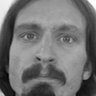

In [12]:
training_set['Image_Object'][0]

In [13]:
training_set['Image_Array'][0]

[[[0.9333333373069763,
   0.9254902005195618,
   0.929411768913269,
   0.9333333373069763,
   0.9411764740943909,
   0.9411764740943909,
   0.9372549057006836,
   0.9450980424880981,
   0.9450980424880981,
   0.9529411792755127,
   0.9411764740943909,
   0.9372549057006836,
   0.9058823585510254,
   0.8313725590705872,
   0.7450980544090271,
   0.6784313917160034,
   0.5803921818733215,
   0.47843137383461,
   0.40784314274787903,
   0.3607843220233917,
   0.30980393290519714,
   0.2862745225429535,
   0.29019609093666077,
   0.2862745225429535,
   0.2862745225429535,
   0.29019609093666077,
   0.3176470696926117,
   0.29019609093666077,
   0.23529411852359772,
   0.250980406999588,
   0.29411765933036804,
   0.33725491166114807,
   0.364705890417099,
   0.4000000059604645,
   0.3921568691730499,
   0.4117647111415863,
   0.4274509847164154,
   0.4470588266849518,
   0.4745098054409027,
   0.49803921580314636,
   0.5176470875740051,
   0.5254902243614197,
   0.5372549295425415,
   0.53

In [14]:
np.array(training_set['Image_Array'][0]).shape

(1, 96, 96)

### Data Grouping

In [19]:
# Eye center, Nose, Mouth center bottom (Shared model)
group0_columns = [
    'left_eye_center_x', 'left_eye_center_y',
    'right_eye_center_x', 'right_eye_center_y',
    'nose_tip_x', 'nose_tip_y',
    'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
    'Image_Array'
]
# Eye inner and outer group
group1_columns = [
    'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
    'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
    'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
    'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
    'Image_Array'
]
# Eyebrow group
group2_columns = [
    'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
    'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
    'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
    'Image_Array'
]

# Mouth center corner group
group3_columns = [
    'mouth_left_corner_x', 'mouth_left_corner_y',
    'mouth_right_corner_x', 'mouth_right_corner_y',
    'Image_Array'
]
# Mouth center top group
group4_columns = [
    'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
    'Image_Array'
]

# Extract data for each set of key points
data_group0 = training_set[group0_columns].dropna()
data_group1 = training_set[group1_columns].dropna()
data_group2 = training_set[group2_columns].dropna()
data_group3 = training_set[group3_columns].dropna()
data_group4 = training_set[group4_columns].dropna()

In [16]:
data_group0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 0 to 7048
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7000 non-null   float64
 1   left_eye_center_y          7000 non-null   float64
 2   right_eye_center_x         7000 non-null   float64
 3   right_eye_center_y         7000 non-null   float64
 4   nose_tip_x                 7000 non-null   float64
 5   nose_tip_y                 7000 non-null   float64
 6   mouth_center_bottom_lip_x  7000 non-null   float64
 7   mouth_center_bottom_lip_y  7000 non-null   float64
 8   Image_Array                7000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 546.9+ KB


In [17]:
data_group0

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image_Array
0,0.687850,0.406274,0.314865,0.379392,0.462714,0.594446,0.449278,0.880060,"[[[0.9333333373069763, 0.9254902005195618, 0.9..."
1,0.670135,0.364272,0.311972,0.348424,0.502149,0.579801,0.473624,0.890418,"[[[0.8588235378265381, 0.843137264251709, 0.80..."
2,0.677678,0.363642,0.321914,0.363642,0.495388,0.557697,0.492447,0.819368,"[[[0.5647059082984924, 0.5568627715110779, 0.6..."
3,0.679435,0.388143,0.333574,0.388143,0.540470,0.564235,0.537096,0.815296,"[[[0.7568627595901489, 0.7529411911964417, 0.7..."
4,0.695055,0.412721,0.335883,0.396271,0.451037,0.675933,0.460699,0.904908,"[[[0.5764706134796143, 0.5803921818733215, 0.6..."
...,...,...,...,...,...,...,...,...,...
7044,0.702110,0.331693,0.309862,0.402426,0.502770,0.698220,0.525277,0.830041,"[[[0.27843138575553894, 0.29019609093666077, 0..."
7045,0.688900,0.399641,0.317486,0.416148,0.499066,0.694021,0.523827,0.812323,"[[[0.23529411852359772, 0.23529411852359772, 0..."
7046,0.694695,0.383804,0.329859,0.413386,0.515235,0.703283,0.515235,0.813720,"[[[0.29019609093666077, 0.29019609093666077, 0..."
7047,0.739220,0.415142,0.318159,0.424712,0.528690,0.695052,0.521512,0.829025,"[[[0.9960784316062927, 0.9960784316062927, 0.9..."


### Model Design

In [21]:
class SharedModel(nn.Module):
    def __init__(self):
        super(SharedModel, self).__init__()
        # Shared feature extraction layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc_shared = nn.Linear(128 * 12 * 12, 256)

        # Independent task branch
        self.fc_eye = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Eye center: 4 coordinates
        )
        self.fc_nose = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Nose tip: 2 coordinates
        )
        self.fc_mouth = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Mouth center bottom: 2 coordinates
        )

    def forward(self, x):
        # Shared feature extraction
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        shared_features = torch.relu(self.fc_shared(x))

        # Independent task output
        eye_output = self.fc_eye(shared_features)
        nose_output = self.fc_nose(shared_features)
        mouth_output = self.fc_mouth(shared_features)

        return eye_output, nose_output, mouth_output

| **Layer Name**      | **Input Shape**           | **Output Shape**          |
|----------------------|---------------------------|---------------------------|
| **Input Image**      | `(batch_size, 1, 96, 96)` | `(batch_size, 1, 96, 96)` |
| **Conv1**            | `(batch_size, 1, 96, 96)` | `(batch_size, 32, 96, 96)` |
| **Pool1**            | `(batch_size, 32, 96, 96)`| `(batch_size, 32, 48, 48)` |
| **Conv2**            | `(batch_size, 32, 48, 48)`| `(batch_size, 64, 48, 48)` |
| **Pool2**            | `(batch_size, 64, 48, 48)`| `(batch_size, 64, 24, 24)` |
| **Conv3**            | `(batch_size, 64, 24, 24)`| `(batch_size, 128, 24, 24)`|
| **Pool3**            | `(batch_size, 128, 24, 24)`| `(batch_size, 128, 12, 12)`|
| **Flatten**          | `(batch_size, 128, 12, 12)`| `(batch_size, 18432)`     |
| **FC Shared**        | `(batch_size, 18432)`     | `(batch_size, 256)`       |
| **Eye Output**       | `(batch_size, 256)`       | `(batch_size, 4)`         |
| **Nose Output**      | `(batch_size, 256)`       | `(batch_size, 2)`         |
| **Mouth Output**     | `(batch_size, 256)`       | `(batch_size, 2)`         |

In [23]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)  # Global Average Pooling
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class SubModelWithAttention(nn.Module):
    def __init__(self, output_size):
        super(SubModelWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.se_block = SEBlock(128)  # Add channel attention
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, output_size)  # Output coordinates

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.se_block(x)  # Attention Mechanism
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

| **Layer Name**      | **Input Shape**           | **Output Shape**          |
|----------------------|---------------------------|---------------------------|
| **Input Image**      | `(batch_size, 1, 96, 96)` | `(batch_size, 1, 96, 96)` |
| **Conv1**            | `(batch_size, 1, 96, 96)` | `(batch_size, 32, 96, 96)` |
| **Pool1**            | `(batch_size, 32, 96, 96)`| `(batch_size, 32, 48, 48)` |
| **Conv2**            | `(batch_size, 32, 48, 48)`| `(batch_size, 64, 48, 48)` |
| **Pool2**            | `(batch_size, 64, 48, 48)`| `(batch_size, 64, 24, 24)` |
| **Conv3**            | `(batch_size, 64, 24, 24)`| `(batch_size, 128, 24, 24)`|
| **Pool3**            | `(batch_size, 128, 24, 24)`| `(batch_size, 128, 12, 12)`|
| **SEBlock**          | `(batch_size, 128, 12, 12)`| `(batch_size, 128, 12, 12)`|
| **Flatten**          | `(batch_size, 128, 12, 12)`| `(batch_size, 18432)`     |
| **FC1**              | `(batch_size, 18432)`     | `(batch_size, 256)`       |
| **FC2**              | `(batch_size, 256)`       | `(batch_size, 12)`         |

### Data Preparation

In [25]:
def extract_image_tensor(df, column_name):
    # Extract the image array column
    image_array = np.stack(df[column_name].values) # Shape is (batch_size, height, width)
    return torch.tensor(image_array, dtype=torch.float32)

In [27]:
class KeypointDataset(Dataset):
    def __init__(self, dataframe):
        keypoint_columns = [col for col in dataframe.columns if col != 'Image_Array']
        self.images = extract_image_tensor(dataframe, 'Image_Array')
        self.keypoints = torch.tensor(dataframe[keypoint_columns].values, dtype=torch.float32) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Returns image and keypoint data
        return self.images[idx], self.keypoints[idx]

In [29]:
dataset_group0 = KeypointDataset(data_group0)
dataset_group1 = KeypointDataset(data_group1)
dataset_group2 = KeypointDataset(data_group2)
dataset_group3 = KeypointDataset(data_group3)
dataset_group4 = KeypointDataset(data_group4)

# Create a DataLoader, set the batch size and whether to shuffle the data
dataloader_group0 = DataLoader(dataset_group0, batch_size=32, shuffle=True)
dataloader_group1 = DataLoader(dataset_group1, batch_size=32, shuffle=True)
dataloader_group2 = DataLoader(dataset_group2, batch_size=32, shuffle=True)
dataloader_group3 = DataLoader(dataset_group3, batch_size=32, shuffle=True)
dataloader_group4 = DataLoader(dataset_group4, batch_size=32, shuffle=True)

In [33]:
# Check DataLoader output
for images, keypoints in dataloader_group0:
    print("Images shape:", images.shape) # should be (batch_size, 1, 96, 96)
    print("Keypoints shape:", keypoints.shape) # should be (batch_size, 8)
    print("Sample Image Tensor:", images[0]) # View the first image tensor
    print("Sample Keypoints:", keypoints[0]) # View the first keypoint
    break

Images shape: torch.Size([32, 1, 96, 96])
Keypoints shape: torch.Size([32, 8])
Sample Image Tensor: tensor([[[0.8471, 0.7373, 0.6667,  ..., 0.1412, 0.1451, 0.2745],
         [0.8157, 0.7255, 0.7647,  ..., 0.1608, 0.1882, 0.2157],
         [0.7412, 0.7216, 0.7961,  ..., 0.1373, 0.1569, 0.1882],
         ...,
         [0.8039, 0.8039, 0.8039,  ..., 0.5490, 0.5412, 0.5255],
         [0.8000, 0.8000, 0.8000,  ..., 0.5529, 0.5451, 0.5255],
         [0.7961, 0.7961, 0.7961,  ..., 0.5569, 0.5412, 0.5216]]])
Sample Keypoints: tensor([0.6814, 0.3495, 0.3124, 0.4252, 0.5035, 0.6789, 0.5397, 0.8041])


### Loss Function (RMSE)

In [31]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()  # MSELoss with PyTorch

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + 1e-8)  # Avoid sqrt(0) causing abnormal gradients
        return loss

### Model Defination

In [33]:
model0 = SharedModel()
model1 = SubModelWithAttention(len(data_group1.columns)-1)
model2 = SubModelWithAttention(len(data_group2.columns)-1)
model3 = SubModelWithAttention(len(data_group3.columns)-1)
model4 = SubModelWithAttention(len(data_group4.columns)-1)

### Parameter Settings

In [35]:
# Define RMSE loss function
criterion = RMSELoss()

# Define training epochs
SharedModel_epochs = 50
SubModel_epochs = 50

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

# Define optimizer
optimizer0 = torch.optim.Adam(model0.parameters(), lr=0.001)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.001)

Available device: cpu


### Set Testing Data Loader

In [36]:
def create_testing_dataloader(df, test_size=0.2, batch_size=128):
    test_df = df.sample(frac=test_size, random_state=1).reset_index(drop=True) # Randomly extract test set
    test_dataset = KeypointDataset(test_df) # Create test set Dataset
    testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Create test set DataLoader
    return testing_dataloader

In [45]:
val_dataloader_group0 = create_testing_dataloader(data_group0)
val_dataloader_group1 = create_testing_dataloader(data_group1)
val_dataloader_group2 = create_testing_dataloader(data_group2)
val_dataloader_group3 = create_testing_dataloader(data_group3)
val_dataloader_group4 = create_testing_dataloader(data_group4)

### Shared Model Training

In [46]:
# move model to gpu
model0 = model0.to(device)

for epoch in range(SharedModel_epochs):
    
    # Training phase
    model0.train()
    running_loss = 0.0
    
    for images, keypoints in dataloader_group0:
        # Moving data to the GPU
        images = images.to(device)  # Image data
        keypoints = keypoints.to(device)  # Keypoint Labels

        # Zero gradient
        optimizer0.zero_grad()

        # Forward Propagation
        outputs = model0(images)

        # Calculating Losses
        eye_output, nose_output, mouth_output = outputs
        loss_eye = criterion(eye_output, keypoints[:, :4])
        loss_nose = criterion(nose_output, keypoints[:, 4:6])
        loss_mouth = criterion(mouth_output, keypoints[:, 6:])
        loss = loss_eye + loss_nose + loss_mouth

        # Backpropagation and optimization
        loss.backward()
        optimizer0.step()

        running_loss += loss.item()

    # Validation phase
    model0.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation
        for images, keypoints in val_dataloader_group0:  
            # Move data to GPU
            images = images.to(device)
            keypoints = keypoints.to(device)

            # Forward propagation
            outputs = model0(images)

            # Calculate validation losses
            eye_output, nose_output, mouth_output = outputs
            loss_eye = criterion(eye_output, keypoints[:, :4])
            loss_nose = criterion(nose_output, keypoints[:, 4:6])
            loss_mouth = criterion(mouth_output, keypoints[:, 6:])
            loss = loss_eye + loss_nose + loss_mouth

            val_loss += loss.item()

    # Print training and validation losses
    print(f"Epoch {epoch+1}/{SharedModel_epochs}, "
          f"Training Loss: {running_loss / len(dataloader_group0):.4f}, "
          f"Validation Loss: {val_loss / len(val_dataloader_group0):.4f}")

Epoch 1/50, Training Loss: 0.1695, Validation Loss: 0.1270
Epoch 2/50, Training Loss: 0.1239, Validation Loss: 0.1254
Epoch 3/50, Training Loss: 0.1069, Validation Loss: 0.1020
Epoch 4/50, Training Loss: 0.0996, Validation Loss: 0.0916
Epoch 5/50, Training Loss: 0.0927, Validation Loss: 0.0971
Epoch 6/50, Training Loss: 0.0844, Validation Loss: 0.0779
Epoch 7/50, Training Loss: 0.0842, Validation Loss: 0.0777
Epoch 8/50, Training Loss: 0.0766, Validation Loss: 0.0752
Epoch 9/50, Training Loss: 0.0741, Validation Loss: 0.0737
Epoch 10/50, Training Loss: 0.0711, Validation Loss: 0.0690
Epoch 11/50, Training Loss: 0.0675, Validation Loss: 0.0743
Epoch 12/50, Training Loss: 0.0623, Validation Loss: 0.0594
Epoch 13/50, Training Loss: 0.0610, Validation Loss: 0.0578
Epoch 14/50, Training Loss: 0.0595, Validation Loss: 0.0606
Epoch 15/50, Training Loss: 0.0572, Validation Loss: 0.0635
Epoch 16/50, Training Loss: 0.0555, Validation Loss: 0.0506
Epoch 17/50, Training Loss: 0.0530, Validation Lo

### SubModel Training

In [47]:
# SubModels and corresponding data loaders
models = {
'model1': {'model': model1, 'train_loader': dataloader_group1, 'val_loader': val_dataloader_group1, 'optimizer': optimizer1},
'model2': {'model': model2, 'train_loader': dataloader_group2, 'val_loader': val_dataloader_group2, 'optimizer': optimizer2},
'model3': {'model': model3, 'train_loader': dataloader_group3, 'val_loader': val_dataloader_group3, 'optimizer': optimizer3},
'model4': {'model': model4, 'train_loader': dataloader_group4, 'val_loader': val_dataloader_group4, 'optimizer': optimizer4},
}

In [48]:
# Define training and validation functions
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    """
    Train and validate a single model.
    """
    model = model.to(device) # Move the model to the GPU

    for epoch in range(epochs):
        
        # Training phase 
        model.train() # Set the model to training mode
        running_loss = 0.0
    
        for images, keypoints in train_loader:
            # Move data to GPU
            images = images.to(device)
            keypoints = keypoints.to(device)
        
            # Clear gradients
            optimizer.zero_grad()
        
            # Forward propagation
            outputs = model(images)
        
            # Calculate loss
            loss = criterion(outputs, keypoints)
            loss.backward() # Backward propagation
            optimizer.step() # Update parameters
        
            running_loss += loss.item()

        # Validation phase 
        model.eval() # Set the model to validation mode
        val_loss = 0.0
        with torch.no_grad():
            for images, keypoints in val_loader:
                # Move data to GPU
                images = images.to(device)
                keypoints = keypoints.to(device)
        
                # Forward propagation
                outputs = model(images)
                
                # Calculate validation loss
                loss = criterion(outputs, keypoints)
                val_loss += loss.item()

        # Print training and validation losses
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {running_loss / len(dataloader_group0):.4f}, "
              f"Validation Loss: {val_loss / len(val_dataloader_group0):.4f}")

# Define global training function
def train_all_models(models, criterion, device, epochs):
    """
    Train all models.
    """
    for model_name, model_info in models.items():
        print(f"\nTraining {model_name}")
        train_and_validate(
            model=model_info['model'],
            train_loader=model_info['train_loader'],
            val_loader=model_info['val_loader'],
            optimizer=model_info['optimizer'],
            criterion=criterion,
            device=device,
            epochs=epochs
        )

# Train all models
train_all_models(models, criterion, device, epochs=20)


Training model1
Epoch 1/20, Training Loss: 0.0269, Validation Loss: 0.0109
Epoch 2/20, Training Loss: 0.0086, Validation Loss: 0.0093
Epoch 3/20, Training Loss: 0.0075, Validation Loss: 0.0094
Epoch 4/20, Training Loss: 0.0070, Validation Loss: 0.0076
Epoch 5/20, Training Loss: 0.0066, Validation Loss: 0.0067
Epoch 6/20, Training Loss: 0.0059, Validation Loss: 0.0067
Epoch 7/20, Training Loss: 0.0057, Validation Loss: 0.0066
Epoch 8/20, Training Loss: 0.0058, Validation Loss: 0.0073
Epoch 9/20, Training Loss: 0.0057, Validation Loss: 0.0092
Epoch 10/20, Training Loss: 0.0051, Validation Loss: 0.0059
Epoch 11/20, Training Loss: 0.0049, Validation Loss: 0.0046
Epoch 12/20, Training Loss: 0.0051, Validation Loss: 0.0060
Epoch 13/20, Training Loss: 0.0047, Validation Loss: 0.0050
Epoch 14/20, Training Loss: 0.0047, Validation Loss: 0.0068
Epoch 15/20, Training Loss: 0.0042, Validation Loss: 0.0044
Epoch 16/20, Training Loss: 0.0038, Validation Loss: 0.0043
Epoch 17/20, Training Loss: 0.00

### Save The Trained Model 

In [408]:
models = {
    'model0': {'model': model0, 'optimizer': optimizer0},
    'model1': {'model': model1, 'optimizer': optimizer1},
    'model2': {'model': model2, 'optimizer': optimizer2},
    'model3': {'model': model3, 'optimizer': optimizer3},
    'model4': {'model': model4, 'optimizer': optimizer4},
}

In [410]:
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

def save_all_models(models, file_name):
    save_path = os.path.join(save_dir, file_name)

    # Package all models and optimizers
    checkpoint = {
        model_name: {
            "model_state_dict": model_info['model'].state_dict(),
            "optimizer_state_dict": model_info['optimizer'].state_dict()
        }
        for model_name, model_info in models.items()
    }

    # Save to the specified path
    torch.save(checkpoint, save_path)
    print(f"All models and optimizers saved to {save_path}")

save_all_models(models, "models_12_3_21:18.pth")

All models and optimizers saved to ./models/models_12_3_21:18.pth


### Load Trained Models 

In [39]:
# Load the model and optimizer
def load_all_models(models, file_name, save_dir="./models"):
    save_path = os.path.join(save_dir, file_name)

    # Check if the file exists
    if not os.path.exists(save_path):
        raise FileNotFoundError(f"{save_path} does not exist.")

    # Load the checkpoint
    checkpoint = torch.load(save_path, map_location=torch.device('cpu'))
    print(f"Loaded models and optimizers from {save_path}")

    # Restore models and optimizers
    for model_name, model_info in models.items():
        if model_name in checkpoint:
            model_info['model'].load_state_dict(checkpoint[model_name]['model_state_dict'])
            model_info['optimizer'].load_state_dict(checkpoint[model_name]['optimizer_state_dict'])
        else:
            print(f"Warning: {model_name} not found in checkpoint.")

    return models

In [41]:
trained_models = load_all_models(models, 'models_12_3_21_18.pth')

Loaded models and optimizers from ./models/models_12_3_21_18.pth


/var/folders/sn/lx9b673d4tvgzwgk3h2rmx_w0000gn/T/ipykernel_40727/2017618798.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path, map_locat

In [111]:
def predict_keypoints(model, image, input_size=(96, 96)):
    """
    Input:
    model: trained PyTorch models
    image: input image (PIL.Image or Numpy array)
    input_size: image size required by the model (default 96x96)
    
    Output:
    keypoints: keypoint coordinates predicted by the model, shape (num_keypoints,)
    """
    
    # Make sure the model is in evaluation mode
    model.eval()

    # Resize an image
    image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0)

    # Prediction key points
    with torch.no_grad():
        outputs = model(image_tensor)

    # Analyze the output according to the model structure
    if isinstance(outputs, tuple):  # If the model has multiple outputs (such as eyes, nose, mouth)
        keypoints = torch.cat(outputs, dim=1)  # Splice all outputs
    else:
        keypoints = outputs

    # Restore the predicted keypoints from [0, 1] to the original image coordinates
    keypoints = keypoints.squeeze(0).squeeze(0).numpy()  # Remove the batch dimension
    keypoints = keypoints * np.array([input_size[0], input_size[1]] * (keypoints.shape[0] // 2))
    
    return keypoints

In [45]:
trained_model0 = trained_models['model0']['model']
trained_model1 = trained_models['model1']['model']
trained_model2 = trained_models['model2']['model']
trained_model3 = trained_models['model3']['model']
trained_model4 = trained_models['model4']['model']

### Set Evaluating Dataset 

In [93]:
evl_set = training_set.dropna()

In [95]:
evl_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 0 to 2283
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float64
 1

In [97]:
evl_set.iloc[0][:-3]

left_eye_center_x             0.68785
left_eye_center_y            0.406274
right_eye_center_x           0.314865
right_eye_center_y           0.379392
left_eye_inner_corner_x      0.620647
left_eye_inner_corner_y      0.412994
left_eye_outer_corner_x      0.761774
left_eye_outer_corner_y      0.416354
right_eye_inner_corner_x     0.378714
right_eye_inner_corner_y     0.389473
right_eye_outer_corner_x     0.244301
right_eye_outer_corner_y     0.389473
left_eyebrow_inner_end_x     0.593263
left_eyebrow_inner_end_y     0.302434
left_eyebrow_outer_end_x     0.835699
left_eyebrow_outer_end_y      0.33571
right_eyebrow_inner_end_x    0.419038
right_eyebrow_inner_end_y    0.302108
right_eyebrow_outer_end_x    0.170379
right_eyebrow_outer_end_y    0.308828
nose_tip_x                   0.462714
nose_tip_y                   0.594446
mouth_left_corner_x          0.637451
mouth_left_corner_y          0.833023
mouth_right_corner_x         0.298068
mouth_right_corner_y         0.806135
mouth_center

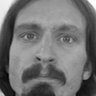

In [99]:
evl_set.iloc[0]['Image_Object']

In [472]:
image = evl_set['Image_Array'][0]

In [474]:
np.array(image).shape

(1, 96, 96)

In [476]:
result = predict_keypoints(trained_model3, image)

In [478]:
result

array([65.09299278, 83.3821907 , 31.37056446, 81.02140617])

### Visualise The Predic Results

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

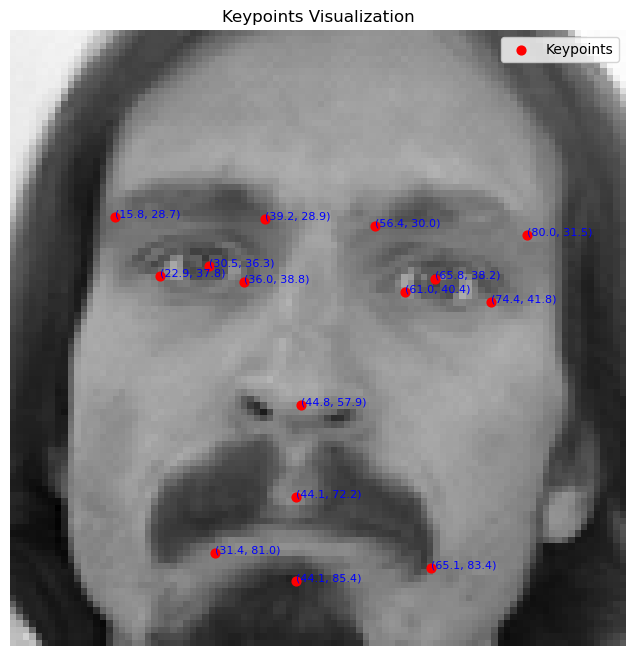

In [404]:
# Load the image
image = np.array(evl_set.iloc[0]['Image_Object'])
keypoints = result.iloc[0].tolist()

# Separate x and y coordinates
x_coords = keypoints[::2] # Even indices are x coordinates
y_coords = keypoints[1::2] # Odd index is y coordinate

# Draw the image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray') # If it is a color image, remove cmap='gray'
plt.scatter(x_coords, y_coords, color='red', s=40, label='Keypoints')

# Add coordinate labels
for x, y in zip(x_coords, y_coords):
    plt.text(x, y, f'({x:.1f}, {y:.1f})', color='blue', fontsize=8)

# Image configuration
plt.axis('off') # Turn off the coordinate axis
plt.legend()
plt.title("Keypoints Visualization")
plt.show()

### Models Combination 

In [458]:
def models_combination_predicts(models, image):
    """
    Predict keypoints using multiple trained models and combine results into a single tensor with feature names.

    Parameters:
    - models (dict): A dictionary where keys are model names and values are dictionaries containing the model objects.
                     Example: {'model0': {'model': model0}, ...}
    - image (torch.Tensor): The input image as a PyTorch tensor.

    Returns:
    - dict: A dictionary containing:
        - 'tensor': A combined tensor of all predictions.
        - 'columns': A list of feature names corresponding to the tensor.
    """
    # List to collect results and corresponding feature names
    results = []
    columns = []

    # Feature name mapping for each model
    feature_names = {
        'model0': ['left_eye_center_x', 'left_eye_center_y',
                   'right_eye_center_x', 'right_eye_center_y',
                   'nose_tip_x', 'nose_tip_y',
                   'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
        'model1': ['left_eye_inner_corner_x', 'left_eye_inner_corner_y',
                   'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
                   'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
                   'right_eye_outer_corner_x', 'right_eye_outer_corner_y'],
        'model2': ['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
                   'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
                   'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
                   'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y'],
        'model3': ['mouth_left_corner_x', 'mouth_left_corner_y',
                   'mouth_right_corner_x', 'mouth_right_corner_y'],
        'model4': ['mouth_center_top_lip_x', 'mouth_center_top_lip_y']
    }

    # Loop through all models
    for model_name, model_data in models.items():
        # Extract the model
        model = model_data['model']
        # Predict keypoints using the model
        prediction = predict_keypoints(model, image)  # Assumes predict_keypoints returns a numpy.ndarray
        # Append prediction to the results list
        results.append(prediction)
        # Append the corresponding feature names
        columns.extend(feature_names[model_name])

    # Concatenate all results along the feature axis
    combined_array = np.concatenate(results).reshape(1, -1)

    return pd.DataFrame(combined_array, columns=columns)

In [446]:
Images = testing_set['Image'].tolist()

In [480]:
testing_set['Image_Array'] = testing_set['Image'].apply(
    lambda x: string_to_normalized_array(x)[np.newaxis, ...].tolist()
)

In [498]:
testing_result = pd.DataFrame()
for i in range(len(testing_set)):
    image = np.array(testing_set['Image_Array'][i])
    testing_result = pd.concat([testing_result, models_combination_predicts(models, image)], axis=0, ignore_index=True)

In [500]:
# reset row index
testing_result.index = range(1, len(testing_result) + 1)

In [553]:
testing_result

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,nose_tip_x,nose_tip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,left_eye_inner_corner_x,left_eye_inner_corner_y,...,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y
1,65.627975,37.617019,29.379647,36.437222,48.997833,52.304283,47.535152,84.938416,59.690781,38.033315,...,36.420854,22.164124,15.633877,23.501156,66.147972,78.829176,36.461886,79.121567,47.521726,68.107870
2,68.382294,36.540155,27.520277,37.164923,49.137726,58.968269,49.081421,88.750729,60.222754,37.939997,...,35.389858,31.204362,12.956171,32.304188,68.044338,78.347569,35.500045,80.081760,47.981584,72.446594
3,65.791866,36.544387,30.997324,37.837077,48.942924,56.995892,49.573179,85.704689,60.912758,37.898555,...,38.134804,29.388285,18.157282,32.531173,65.254515,78.308556,39.309966,79.744566,50.034697,69.358234
4,65.414280,38.024251,31.452538,39.965421,48.105658,53.004501,48.635227,82.729900,59.397560,39.905419,...,38.315506,30.943348,17.349494,35.032082,67.714668,81.268570,36.850777,82.098278,48.384230,70.400654
5,67.050161,37.080872,28.160769,39.764697,48.618874,53.325680,49.498592,85.649265,60.770565,37.738349,...,37.378286,28.500309,13.772109,32.105842,67.320339,80.118107,38.173428,79.596251,48.617409,70.869930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,63.258974,38.453588,31.707175,35.414738,47.689808,62.989683,46.440216,76.072369,58.910053,38.705564,...,42.263815,29.456740,17.162503,30.015821,64.828903,76.004036,33.820061,74.606615,48.023655,70.714365
1780,65.165051,35.860208,29.594499,41.952719,50.495195,64.482101,52.275066,73.345734,57.290325,36.698150,...,36.051161,33.738808,15.841255,38.059791,71.959202,70.827496,39.180187,76.976646,51.250139,69.697929
1781,65.639786,42.806170,32.375696,38.238859,47.252901,68.032001,45.495312,77.776245,59.423985,37.228045,...,40.601269,30.176949,18.033960,28.736315,61.858692,80.867586,32.244292,78.120398,44.655121,74.478951
1782,60.668346,34.546165,30.854822,37.212052,44.093794,61.260143,45.897646,72.023792,56.450237,36.771744,...,39.984724,30.675488,16.015792,35.617350,65.860130,78.750515,34.318242,79.472391,46.439681,71.788456


/var/folders/sn/lx9b673d4tvgzwgk3h2rmx_w0000gn/T/ipykernel_40727/801157802.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(keypoints_columns))


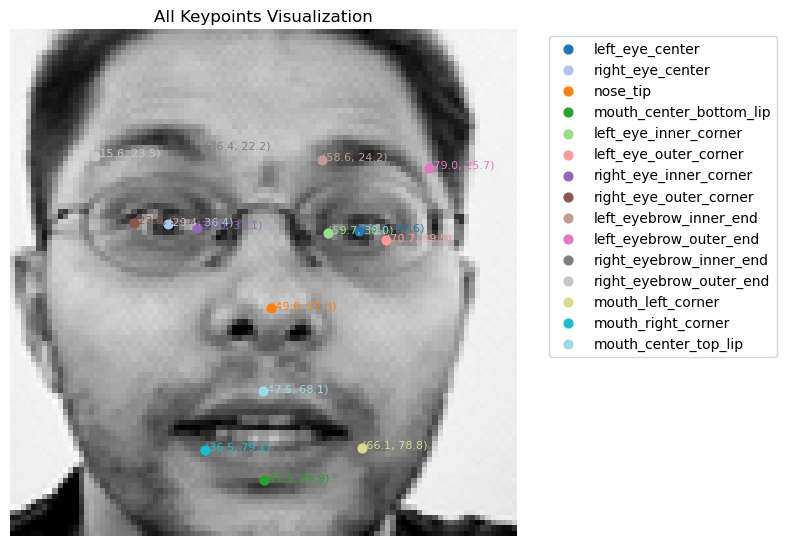

In [536]:
# Load the image
image = np.squeeze(testing_set.iloc[0]['Image_Array'])

# Define all keypoints as (x, y) pairs
keypoints_columns = [
    ('left_eye_center_x', 'left_eye_center_y'),
    ('right_eye_center_x', 'right_eye_center_y'),
    ('nose_tip_x', 'nose_tip_y'),
    ('mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'),
    ('left_eye_inner_corner_x', 'left_eye_inner_corner_y'),
    ('left_eye_outer_corner_x', 'left_eye_outer_corner_y'),
    ('right_eye_inner_corner_x', 'right_eye_inner_corner_y'),
    ('right_eye_outer_corner_x', 'right_eye_outer_corner_y'),
    ('left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y'),
    ('left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y'),
    ('right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y'),
    ('right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y'),
    ('mouth_left_corner_x', 'mouth_left_corner_y'),
    ('mouth_right_corner_x', 'mouth_right_corner_y'),
    ('mouth_center_top_lip_x', 'mouth_center_top_lip_y')
]

# Generate a list of unique colors for each keypoint category
colors = plt.cm.get_cmap('tab20', len(keypoints_columns))

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')  # If the image is in color, remove cmap='gray'

# Iterate over each keypoint and plot
for i, (x_label, y_label) in enumerate(keypoints_columns):
    x = testing_result.loc[1, x_label]
    y = testing_result.loc[1, y_label]
    
    # Plot each point with its specific color
    plt.scatter(x, y, color=colors(i), s=40, label=f'{x_label[:-2]}')  # Remove '_x' for label
    
    # Add text annotation for the keypoint
    plt.text(x, y, f'({x:.1f}, {y:.1f})', color=colors(i), fontsize=8)

# Image configuration
plt.axis('off')  # Hide axis
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.title("All Keypoints Visualization")
plt.tight_layout()
plt.show()

### Filling The IdLookup Table 

In [543]:
IdLookupTable = pd.read_csv('facial-keypoints-detection/IdlookupTable.csv', header=0)

In [545]:
IdLookupTable

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [555]:
for i in range(len(IdLookupTable)):
    ImageId, FeatureName = IdLookupTable.loc[i, ['ImageId', 'FeatureName']]
    IdLookupTable.loc[i, 'Location'] = testing_result.loc[ImageId, FeatureName]

In [557]:
IdLookupTable

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,65.627975
1,2,1,left_eye_center_y,37.617019
2,3,1,right_eye_center_x,29.379647
3,4,1,right_eye_center_y,36.437222
4,5,1,left_eye_inner_corner_x,59.690781
...,...,...,...,...
27119,27120,1783,right_eye_center_y,37.940217
27120,27121,1783,nose_tip_x,48.784801
27121,27122,1783,nose_tip_y,65.731556
27122,27123,1783,mouth_center_bottom_lip_x,49.147156


In [569]:
Output = IdLookupTable.loc[:, ['RowId', 'Location']]

In [571]:
Output

,RowId,Location
0,1,65.627975
1,2,37.617019
2,3,29.379647
3,4,36.437222
4,5,59.690781
...,...,...
27119,27120,37.940217
27120,27121,48.784801
27121,27122,65.731556
27122,27123,49.147156


In [575]:
# Save the upload.csv file
Output.to_csv('facial-keypoints-detection/Output.csv', index=False)  # index=False does not export row index